# Design distal enhancer toward monocyte-specific PPIF expression

In [1]:
import pandas as pd
import bioframe as bf
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import grelu.resources
import grelu.visualize

2024-09-18 02:17:20.168844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 02:17:20.186256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 02:17:20.191519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 02:17:20.204776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 02:17:21.027107: W tensorflow/compiler/tf2

### Coordinates at locus

Coordinates: PPIF locus (hg19 chr10:81,037,448-81,124,761), PPIF enhancer (chr10:81,045,48981,047,143), PPIF promoter (chr10:81,106,967-81,107,535).  

**_hg19_**
- chr10:81037448-81124761 (locus)
- chr10:81045489-81047143 (enhancer)
- chr10:81106967-81107535 (promoter) : 569 bp

**_hg38_**
- chr10:79277691-79365005 (locus)
- chr10:79285732-79287386 (enhancer)
- chr10:79347211-79347779 (promoter): conversion seems correct

### Load model

In [2]:
model = grelu.resources.load_model(
    project="borzoi",
    alias="latest",
    model_name="human_fold0" 
)

wandb: Currently logged in as: lgunsalus (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


## Get experimental data from borzoi training data

### Define plotting intervals

In [3]:
chrom = 'chr10'

enhancer_start = 79285732
enhancer_end = 79287386

# region to plot
plotting_buffer = 10000

chrom = 'chr10'
promoter_start = 79347211
promoter_end = 79347779
query_interval = pd.DataFrame({'chrom':[chrom], 'start':[promoter_start - plotting_buffer], 'end':[promoter_end + plotting_buffer], "strand":["+"],})


### Functionality to pull borzoi training data

In [4]:

def get_seq_mapping(file_path='/gstore/data/resbioai/grelu/borzoi-data/hg38/sequences.bed'):
    """
    Reads the sequence mapping file and processes it to add tf_label, tfrecord, and example_number columns.
    """
    seq_mappingF = pd.read_csv(file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'fold'])
    seq_mappingF['tf_label'] = seq_mappingF.groupby('fold').cumcount() // 16
    seq_mappingF['tfrecord'] = seq_mappingF.apply(lambda row: f"{row['fold']}-{row['tf_label']}.tfr", axis=1)
    seq_mappingF['example_number'] = seq_mappingF.groupby('fold').cumcount() % 16
    return seq_mappingF

def get_fold_from_query(query_interval, seq_mappingF):
    """
    Finds the fold(s) that overlap with the given query interval.
    """
    overlapping_intervals = bf.overlap(query_interval, seq_mappingF, how='inner', suffixes=('_input', ''))
    query_start, query_end = query_interval.loc[0, 'start'], query_interval.loc[0, 'end']
    overlapping_intervals['is_covered'] = (overlapping_intervals['start'] <= query_start) & (overlapping_intervals['end'] >= query_end)
    return overlapping_intervals['fold'].unique()


def get_data_set(model_fold, data_fold):
    """
    Determines whether a data fold is in the train, test, or validation set for a given model fold.
    """
    # Define the fold assignments
    fold_assignments = {
        'f0': {'test': 'fold0', 'val': 'fold1'},
        'f1': {'test': 'fold1', 'val': 'fold2'},
        'f2': {'test': 'fold2', 'val': 'fold3'},
        'f3': {'test': 'fold3', 'val': 'fold4'}
    }
    assignments = fold_assignments.get(model_fold)
    
    if not assignments:
        return "Invalid model fold"
    
    # Determine if the data_fold is in test, val, or train
    if data_fold == assignments['test']:
        return 'test'
    elif data_fold == assignments['val']:
        return 'val'
    else:
        return 'train'


In [5]:
seq_mappingF = get_seq_mapping()

# Get overlapping intervals
overlapping_intervals = bf.overlap(query_interval, seq_mappingF, how='inner', suffixes=('_input', ''))

# Check if the query interval is completely covered by the overlapping intervals
query_start, query_end = query_interval.loc[0, 'start'], query_interval.loc[0, 'end']
overlapping_intervals['is_covered'] = (overlapping_intervals['start'] <= query_start) & (overlapping_intervals['end'] >= query_end)

# Hopefully select an interval that is fully covered by one tfrecord
overlapping_intervals = overlapping_intervals[overlapping_intervals['is_covered']]
selected_record = overlapping_intervals.iloc[0]

In [6]:
feature_map = {
    "target": tf.io.FixedLenFeature([], tf.string),
    "sequence": tf.io.FixedLenFeature([], tf.string),
}

dataset = tf.data.TFRecordDataset(f"/gstore/data/resbioai/grelu/borzoi-data/hg38/tfrecords/{selected_record.tfrecord}", compression_type="ZLIB")


2024-09-18 02:17:30.892079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23303 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0
2024-09-18 02:17:30.893773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 73460 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2024-09-18 02:17:30.895328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79091 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [7]:
# Select locus from training data
i = selected_record.example_number

counter = 0

for raw_record in dataset:
    parsed_record = tf.io.parse_example(raw_record, feature_map)
    sequence = tf.io.decode_raw(parsed_record["sequence"], tf.uint8)
    
    if counter == i:
        break
    
    counter += 1

t= tf.io.decode_raw(parsed_record["target"], tf.float16) 
target = tf.reshape(t, (-1,7611)).numpy() # 7611
target = target.T
target.shape

(7611, 6144)

## Model predictions

### Make model predictions

In [8]:
input_len = model.data_params["train_seq_len"]
remaining_sequence = input_len - (selected_record.end - selected_record.start)
input_start = selected_record.start - remaining_sequence//2
input_end = selected_record.end + remaining_sequence//2
assert((input_end-input_start) == input_len)

input_intervals = pd.DataFrame({
    'chrom':[selected_record.chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})
input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]
preds = model.predict_on_seqs(input_seqs, device='cpu').squeeze()

### Set on-target and off-target tracks

In [40]:
tasks = pd.DataFrame(model.data_params['tasks'])
off_tasks = tasks[(tasks.assay == "RNA") & (tasks["file"].str.contains("GTEX")) & (tasks['description'].str.contains('brain'))].index.tolist()
plot_tasks = tasks[(tasks.assay == "RNA") & (tasks["file"].str.contains("GTEX")) & (tasks['sample']  == 'blood')].index.tolist()
plot_tasks = [7532, 7533] # exclude outlier blood track

plot_bins = model.input_intervals_to_output_bins(
    intervals=query_interval,
    start_pos=input_start
)


## Plot experimental data

In [41]:
def plot_tracks(
    tracks: np.ndarray,
    start_pos: int = 0,
    end_pos: int = None,
    titles = None,
    figsize = (20, 1.5),
    highlight_intervals =  None,
    annotations ={},
    ylim = None,
    fill_color= 'black',
):
    """
    Plot genomic coverage tracks

    Args:
        tracks: Numpy array of shape (T, L)
        start_pos: Coordinate at which the tracks start
        end_pos: Coordinate at which the tracks end
        titles: List containing a title for each track
        figsize: Tuple of (width, height)
        highlight_intervals: A pandas dataframe containing genomic intervals to highlight
        annotations: Dictionary of (key, value) pairs where the keys are strings
            and the values are pandas dataframes containing annotated genomic intervals
    """
    from pygenomeviz.track import FeatureTrack

    # Get parameters
    n_tracks = len(tracks)
    n_annotations = len(annotations)
    track_len = len(tracks[0])
    end_pos = end_pos or track_len
    coord_len = end_pos - start_pos
    bin_size = coord_len // track_len

    # Get plot titles
    if titles is None:
        titles = [""] * n_tracks
    else:
        titles = make_list(titles)

    # Make axes
    fig, axes = plt.subplots(
        n_tracks + n_annotations, 1, figsize=figsize, sharex=True, tight_layout=True
    )
    if n_tracks == 1:
        axes = [axes]

    # Plot the tracks
    for ax, y, title in zip(axes[:n_tracks], tracks, titles):
        ax.fill_between(
            np.linspace(start_pos, end_pos, num=track_len), y, color=fill_color,
        )
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
        #plt.ylim(0,ylim)
        ax.set_ylim([0, ylim])


    # Add highlights
    if highlight_intervals is not None:
        add_highlights(
            ax,
            starts=(highlight_intervals.start - start_pos) // bin_size,
            ends=int(np.ceil((highlight_intervals.end - start_pos) / bin_size)),
        )

    # Plot the annotations
    for ax, (title, ann) in zip(axes[n_tracks:], annotations.items()):
        # Make tracks
        track = FeatureTrack(name=title, size=coord_len, start_pos=start_pos)
        for row in ann.itertuples():
            if "label" in ann.columns:
                track.add_feature(
                    row.start,
                    row.end,
                    row.strand,
                    label=row.label,
                    labelsize=10,
                    labelrotation=0,
                )
            else:
                track.add_feature(row.start, row.end, row.strand)

        # Plot track scale line
        ax.hlines(0, start_pos, end_pos)

        # Plot track label
        ax.set_title(title)

        # Plot features
        for feature in track.features:
            feature.plot_feature(ax, track.size, track.ylim)
            feature.plot_label(ax, track.ylim)

    return fig

7611


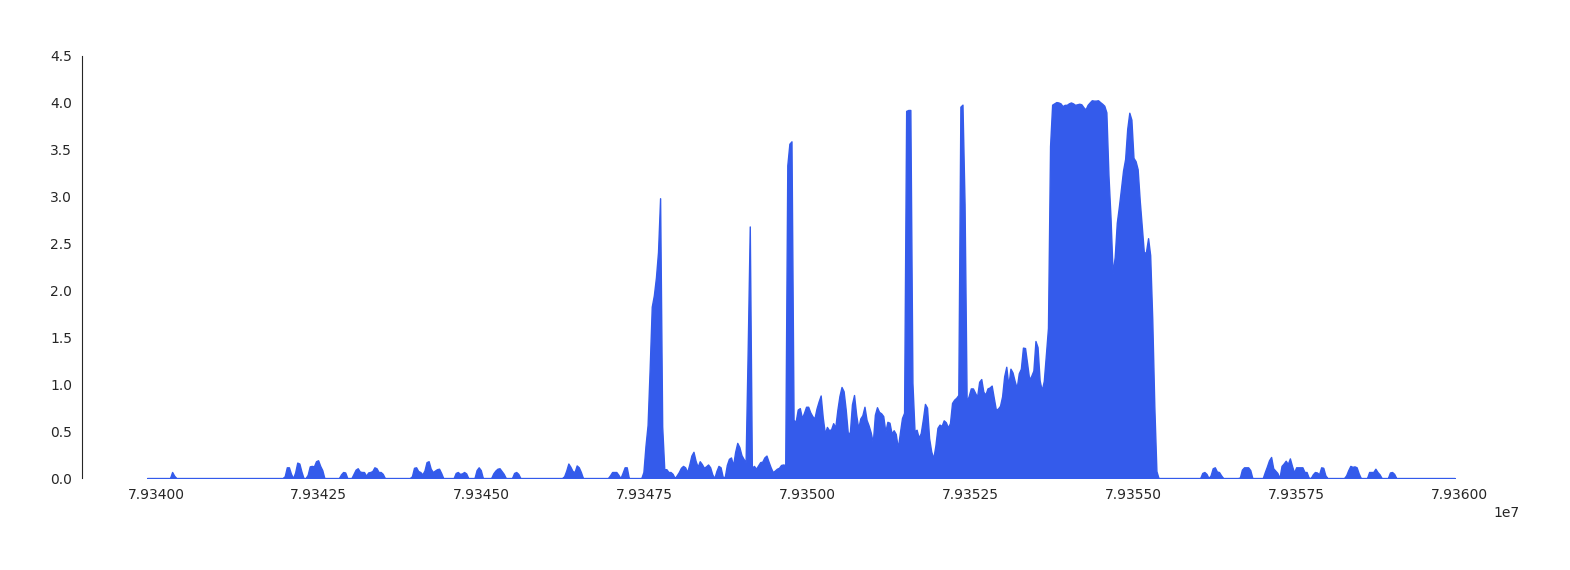

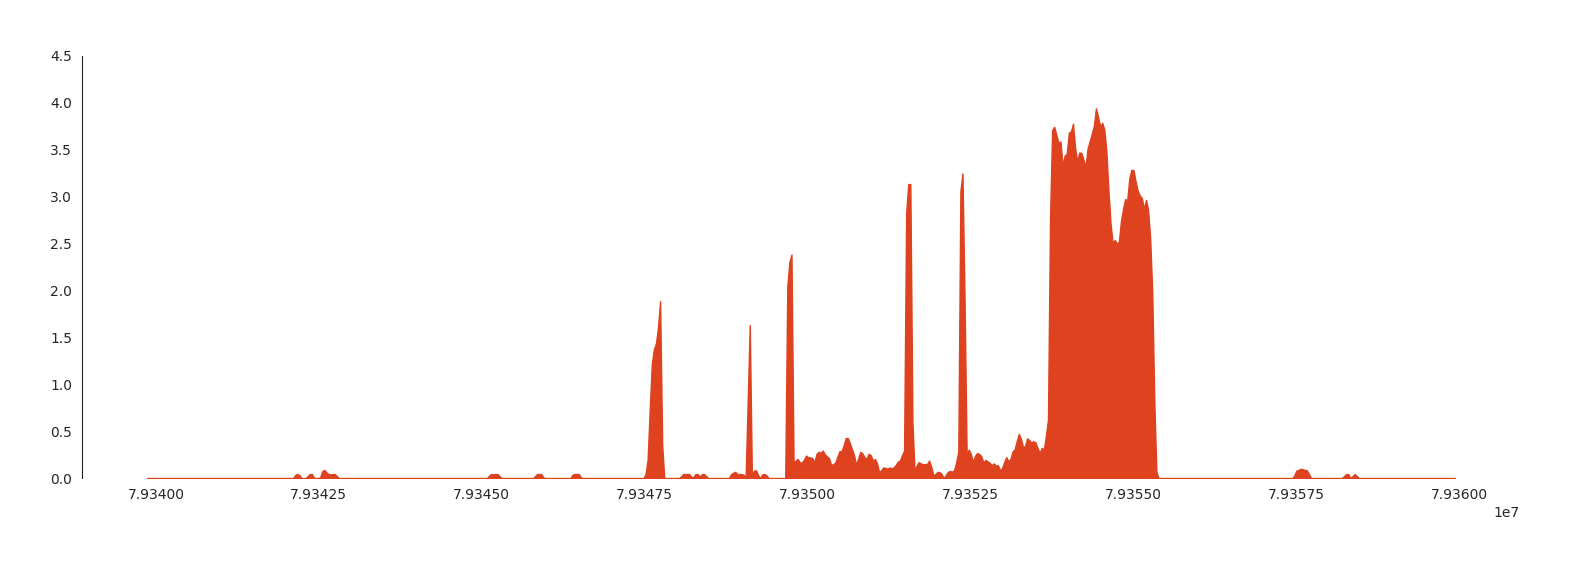

In [88]:
# Target
tasks_to_plot = range(0, 4)
task_names = tasks.description[plot_tasks]
track = np.expand_dims(target[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)
print(len(target))

fig = plot_tracks(
    track,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 4.5,
    fill_color = '#345beb',
)

tracks = np.expand_dims(target[off_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)

fig = plot_tracks(
    tracks,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 4.5,
    fill_color = '#de421f'
)

## Plot model predictions

In [84]:
sns.set_style("white")

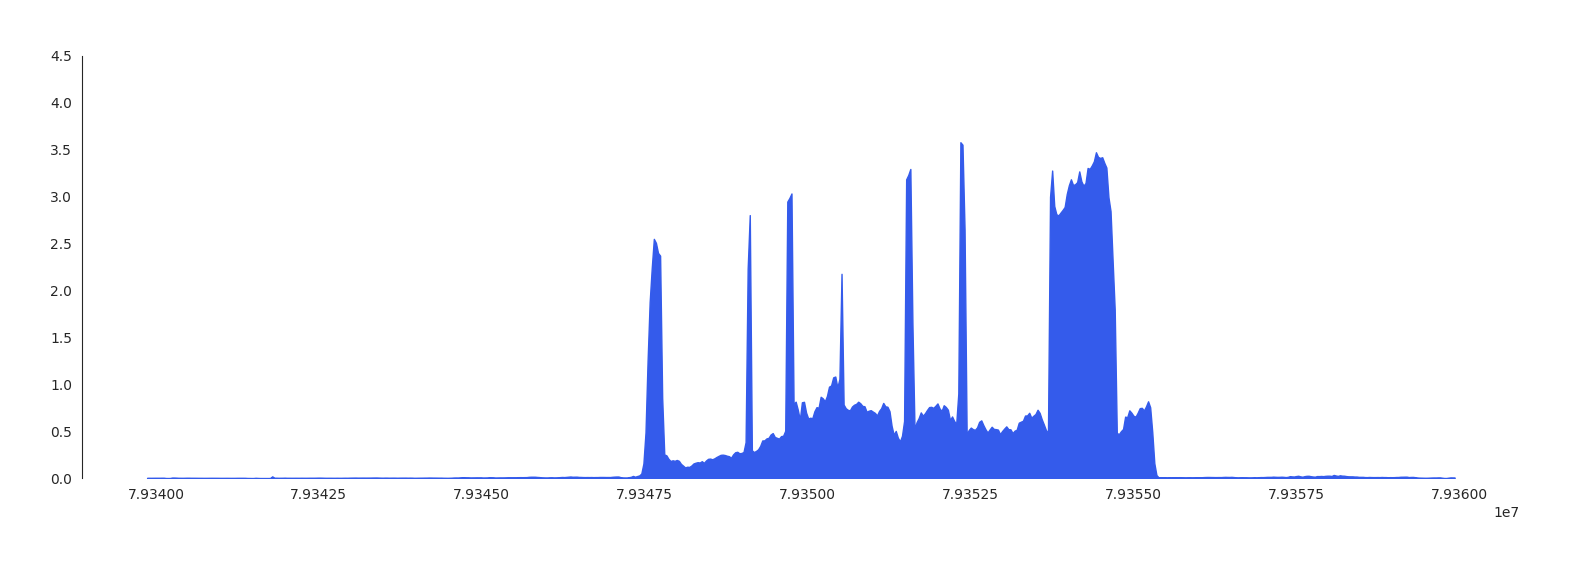

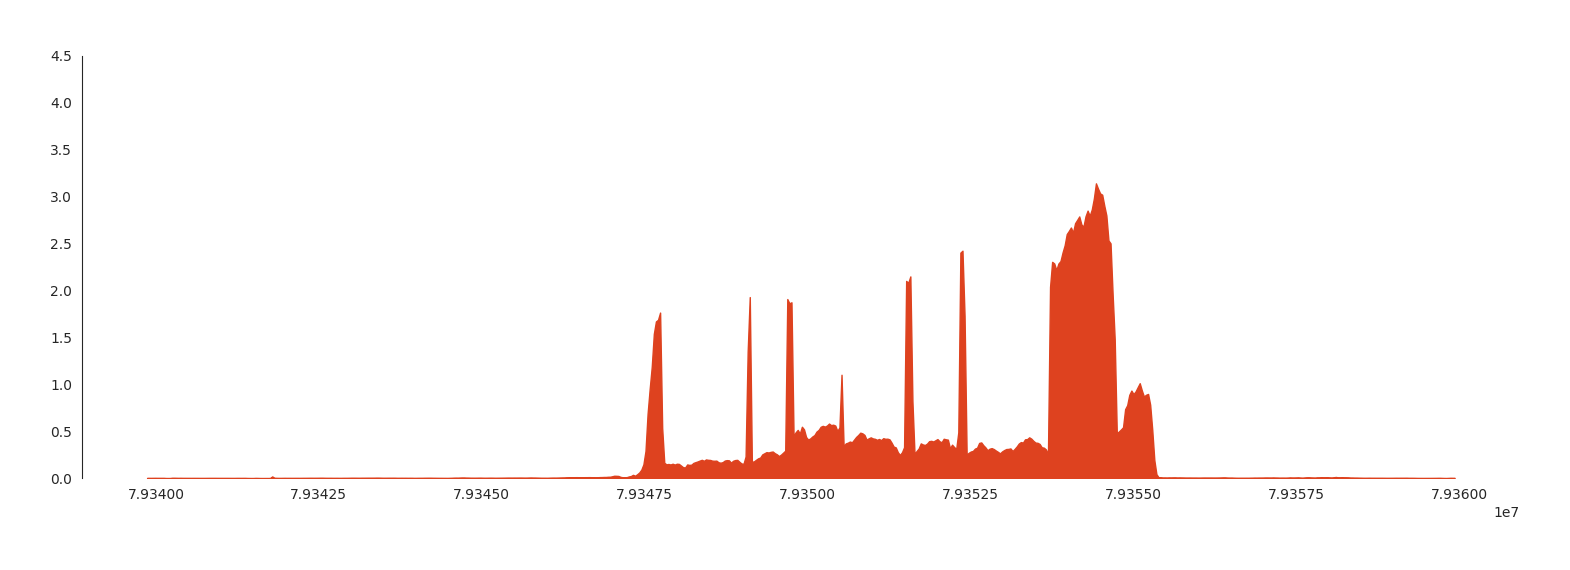

In [89]:
fig = plot_tracks(
    np.expand_dims(preds[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0),
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 4.5,
    fill_color = '#345beb',
)

tracks = np.expand_dims(preds[off_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)

fig = plot_tracks(
    tracks,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 4.5,
    fill_color = '#de421f'
)

### Plot exon annotations

In [44]:
plot_start_coord = 79339864
plot_end_coord = 79359931

promoter_start = 79347211
promoter_end = 79347779

plotF = pd.DataFrame({'chrom': ['chr10'], 'start': [plot_start_coord], 'end': [plot_end_coord]})
plot_bins = model.input_intervals_to_output_bins(
    intervals=plotF,
    start_pos=input_start
)

In [45]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")

In [47]:
exons.head()

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
0,chr1,11874,12227,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
1,chr1,12613,12721,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
2,chr1,13221,14409,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
3,chr1,14362,14829,WASH7P,genomepy,exon,.,-,.,"gene_id ""WASH7P""; transcript_id ""NR_024540.1"";..."
4,chr1,14970,15038,WASH7P,genomepy,exon,.,-,.,"gene_id ""WASH7P""; transcript_id ""NR_024540.1"";..."


In [48]:
import grelu.data.preprocess

exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=plotF,
    method="all"
)

Keeping 12 intervals


In [49]:
genes = exons[['gene_name', 'chrom', 'strand']].drop_duplicates()
genes = genes.merge(exons.groupby("gene_name").start.min().reset_index())
genes = genes.merge(exons.groupby("gene_name").end.max().reset_index())
genes = genes.rename(columns={"gene_name": "label"})

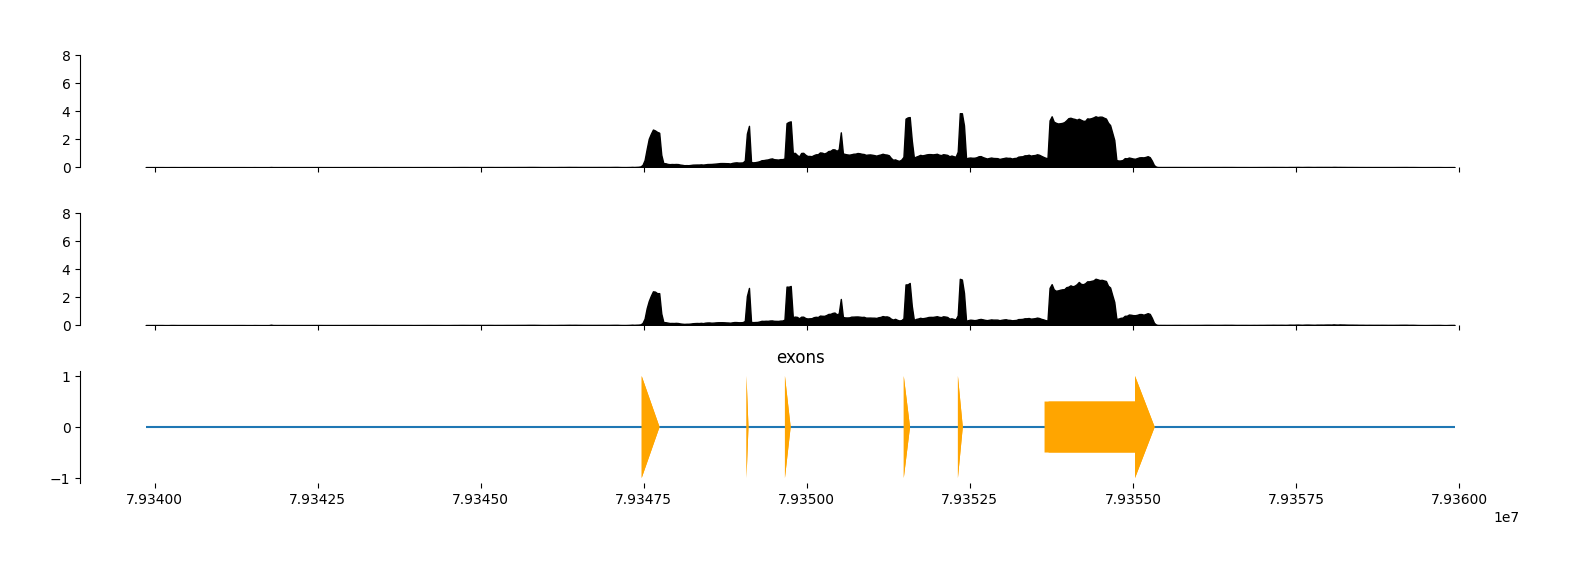

In [50]:
fig = plot_tracks(
    preds[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()],
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    #titles=task_names,           # Description of these tracks from the `tasks` dataframe
    figsize=(15,5),            # width, height
    ylim = 8,
    annotations={"exons":exons},
    
)

## Perform ISM across enhancer sequence

In [51]:
import grelu.interpret.score


ism_start_pos = enhancer_start
ism_end_pos = enhancer_end

ppif_exons = exons[exons.gene_name == "PPIF"]
ppif_exons = model.input_intervals_to_output_bins(
    intervals=ppif_exons,
    start_pos=input_start
)

selected_bins = set()
for row in ppif_exons.itertuples():
    selected_bins = selected_bins.union(list(range(row.bin_start, row.bin_end)))

selected_bins = list(selected_bins)

In [52]:
import grelu.transforms.prediction_transforms

blood_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = plot_tasks, 
    positions = selected_bins,
    task_aggfunc = "mean",
    length_aggfunc = "sum",
)

In [53]:
ism = grelu.interpret.score.ISM_predict(
    seqs=input_seq, 
    model=model,
    genome="hg38",
    prediction_transform=blood_ppif_score,
    devices=1, 
    batch_size=4,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/gunsalul/gReLU-applications/PPIF_design/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1654/1654 [13:30<00:00,  2.04it/s]


In [55]:
#ism.to_csv('ppif_original_enhancer_ism.csv')
ism = pd.read_csv('ppif_original_enhancer_ism', index_col=0)

In [38]:
def clean_column_name(col):
    return ''.join(re.findall(r'[ACTG]', col))
ism.columns = [clean_column_name(col) for col in ism.columns]

### Plot ISM

<Axes: >

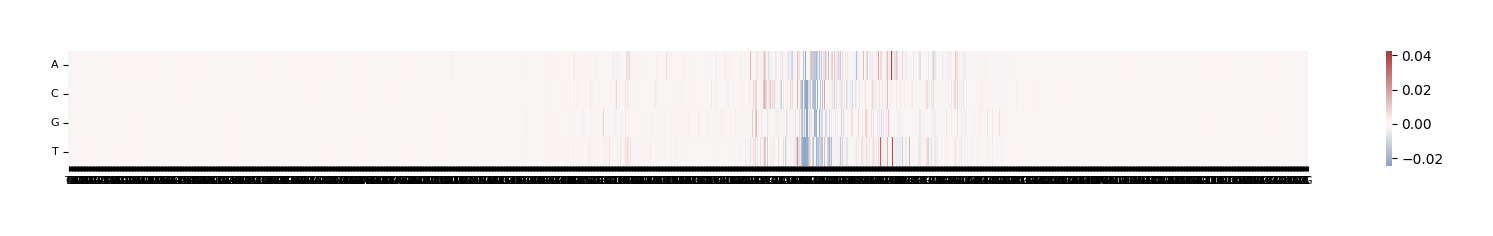

In [56]:
grelu.visualize.plot_ISM(ism, method="heatmap", figsize=(20, 1.5), center=0) 

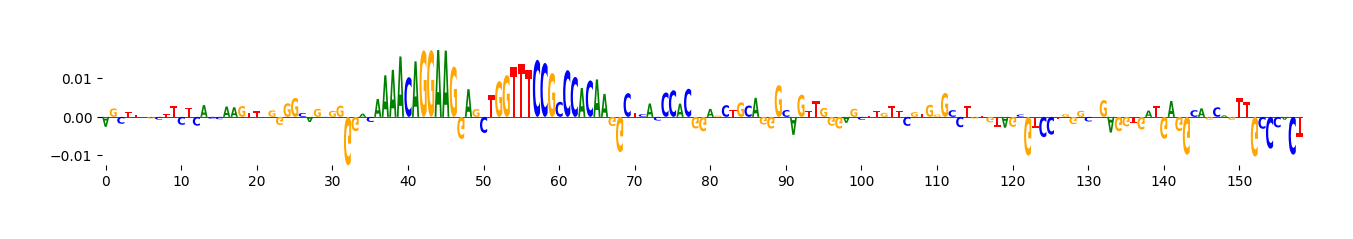

In [57]:
grelu.visualize.plot_ISM(ism, method="logo", figsize=(15.5, 1.5),
                        start_pos=940,end_pos = 1100)

## Evolve enhancer sequence

In [58]:
import grelu.design
from grelu.design import evolve

In [59]:
import grelu.transforms.prediction_transforms

specific_ppif_score = grelu.transforms.prediction_transforms.Specificity(
    on_tasks = plot_tasks, # positive tasks
    off_tasks = off_tasks, # negative tasks
    positions = selected_bins, # The relevant regions of the output
    on_aggfunc = "mean", # Average expression over the positive tasks
    off_aggfunc = "mean", # Average expression over the negative tasks
    length_aggfunc = "mean", # Average expression over the bins
    compare_func = "subtract", # Return the ratio of expression in positive tasks to negative tasks
)

In [66]:
positions = np.arange(enhancer_start, enhancer_end)
positions = positions - input_start

In [67]:
max_iterations = 20

In [ ]:
output = evolve(
    [input_seq], 
    model,
    positions=positions,
    prediction_transform=specific_ppif_score, 
    max_iter=max_iterations,
    num_workers=1,
    devices=1,
    return_seqs="best", # Return all the evolved sequences
    batch_size=4,
    return_preds=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Iteration 0
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 0: 0.421
Iteration 1
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 1: 0.499
Iteration 2
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 2: 0.586
Iteration 3
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 3: 0.693
Iteration 4
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 4: 0.803
Iteration 5
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 5: 0.894
Iteration 6
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 6: 0.981
Iteration 7
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:09<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 7: 1.061
Iteration 8
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:09<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 8: 1.133
Iteration 9
Predicting DataLoader 0:  33%|██████████████████████████████████████████████▏                                                                                            | 412/1241 [03:22<06:46,  2.04it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 10: 1.268
Iteration 11
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 11: 1.325
Iteration 12
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 12: 1.372
Iteration 13
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:09<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 13: 1.448
Iteration 14
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:08<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 14: 1.497
Iteration 15
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [10:09<00:00,  2.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Best value at iteration 15: 1.546
Iteration 16
Predicting DataLoader 0:  57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 713/1241 [05:49<04:19,  2.04it/s]

In [71]:
#output.to_csv('ppif_enhancer_evolution_output.csv')
output = pd.read_csv('ppif_enhancer_evolution_output.csv')

In [72]:
output.shape

(99241, 10)

### Select best sequence

In [73]:
best_seq = output.sort_values("total_score", ascending=False).iloc[0].seq
best_enhancer = best_seq[enhancer_start - input_start:enhancer_end - input_start] 
out = output[output['best_in_iter']]
starting = out.iloc[0].seq[enhancer_start - input_start:enhancer_end - input_start] 
ending = out.iloc[20].seq[enhancer_start - input_start:enhancer_end - input_start] 

### Plot specificity across evolution 

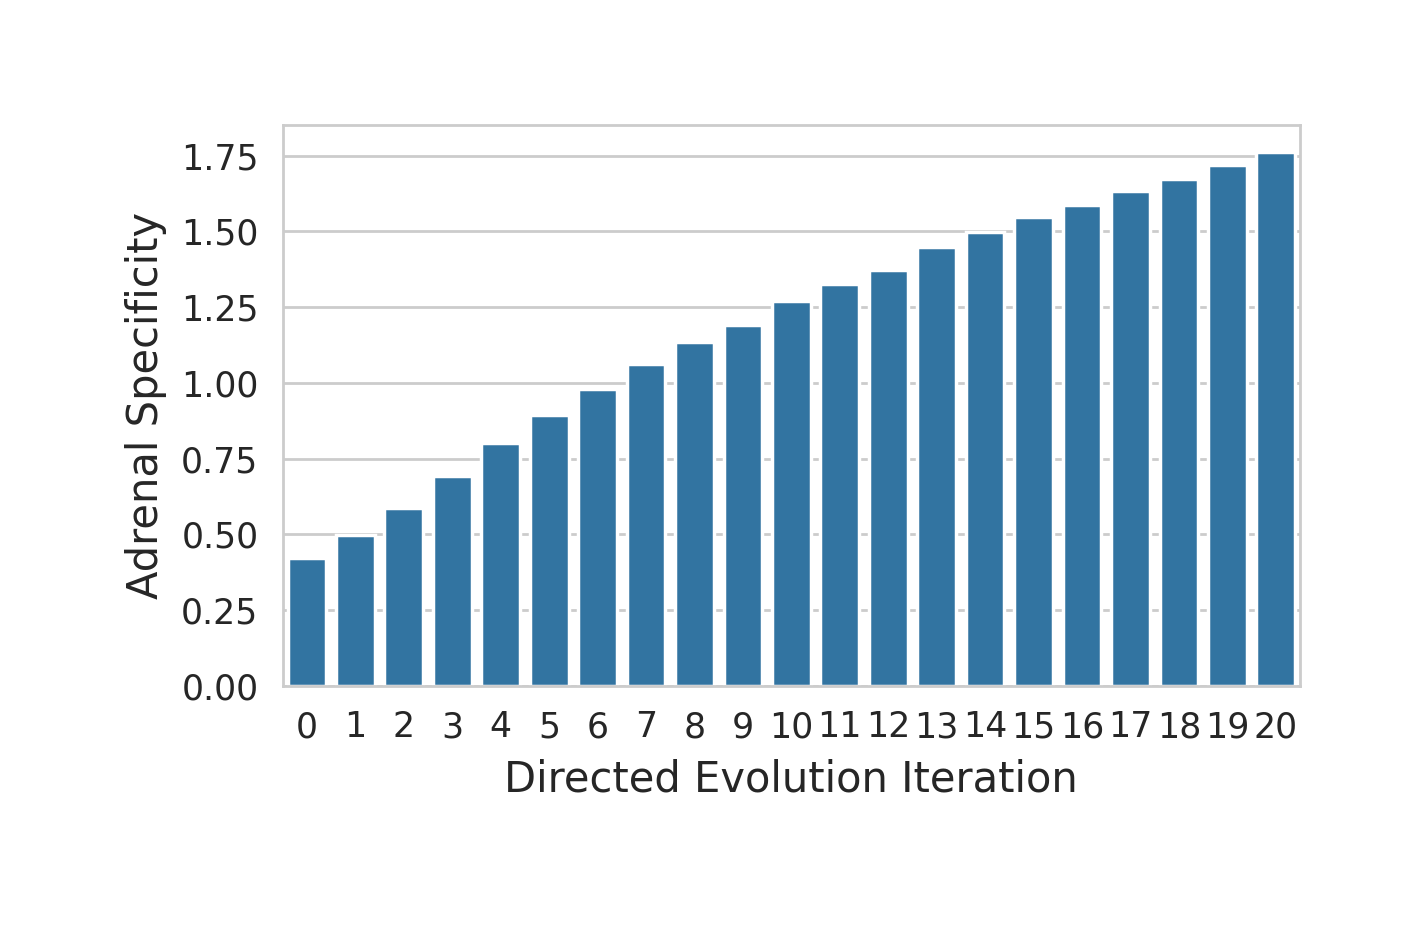

In [74]:
import matplotlib as mpl
sns.set_style("whitegrid")
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

plt.figure(figsize=(5,3), dpi=250)

# Create the box plot
ax = sns.barplot(data=out, x='iter', y='prediction_score')#, palette='viridis')

# Customize the plot
plt.xlabel('Directed Evolution Iteration', fontsize=12)
plt.ylabel('Adrenal Specificity', fontsize=12)

plt.tight_layout()
plt.show()

### Calculate specificity of sequences

In [75]:
import grelu.transforms.prediction_transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [76]:
adrenal_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = plot_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

brain_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = off_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

In [77]:
device = 'cuda:1'
model = model.to(device)

In [78]:

scores_data = []
out = out.reset_index()

for i, row in out.iterrows():
    seq = row['seq']
    pred = model.predict_on_seqs(seq, device=device)
    
    blood_scores = adrenal_ppif_score.compute(pred)
    brain_scores = brain_ppif_score.compute(pred)
    
    # Flatten the nested lists
    blood_scores_flat = [score for sublist in blood_scores for score in sublist]
    brain_scores_flat = [score for sublist in brain_scores for score in sublist]
    
    for blood_score in blood_scores_flat:
        scores_data.append({
            'round': i,
            'tissue': 'blood',
            'score': blood_score[0]
        })
    
    for brain_score in brain_scores_flat:
        scores_data.append({
            'round': i,
            'tissue': 'brain',
            'score': brain_score[0]
        })
    
scores = pd.DataFrame(scores_data)

In [80]:
scores

,round,tissue,score
0,0,blood,2.294451
1,0,blood,1.996319
2,0,brain,1.772357
3,0,brain,1.624181
4,0,brain,1.775445
...,...,...,...
100,20,blood,3.212444
101,20,blood,3.406672
102,20,brain,1.545070
103,20,brain,1.534776


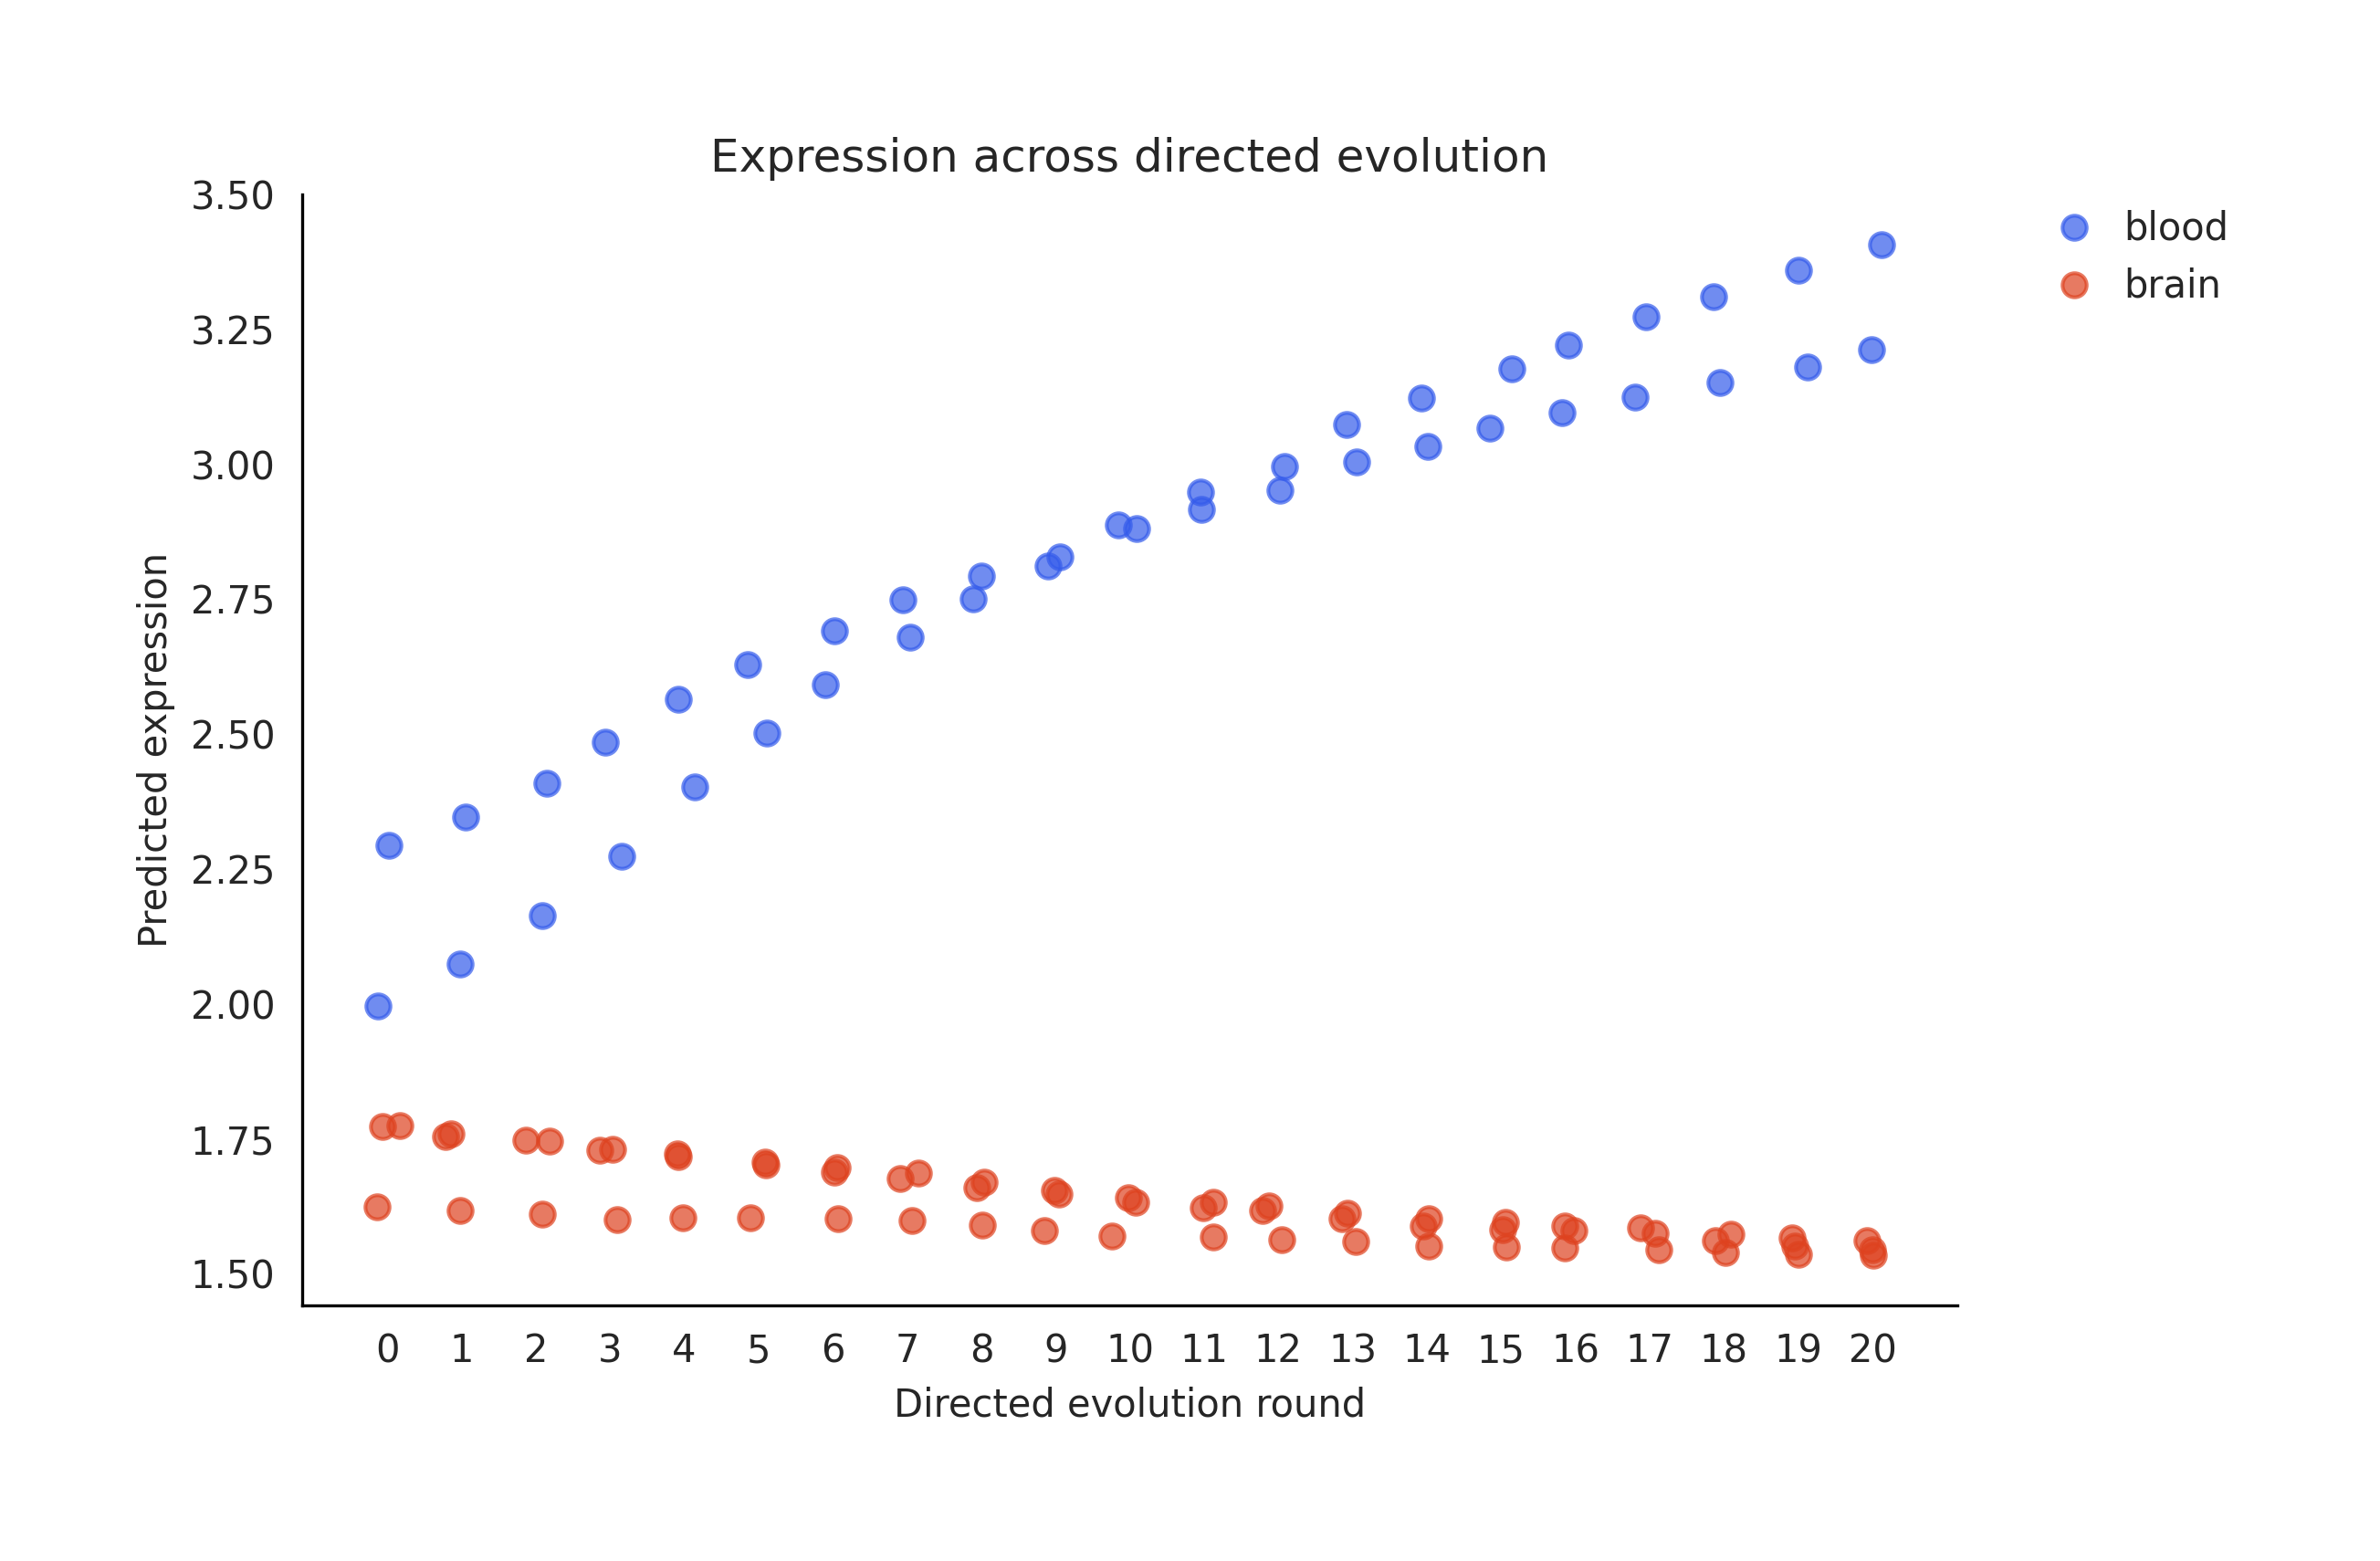

In [90]:

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
for tissue, color in zip(['blood', 'brain'], ['#345beb', '#de421f']):
    tissue_data = scores[scores['tissue'] == tissue]
    
    # Add jitter to the x-axis (round values)
    jittered_x = tissue_data['round'].astype(float) + np.random.normal(0, 0.1, len(tissue_data))
    
    ax.scatter(jittered_x, tissue_data['score'], color=color, label=tissue, alpha=0.7, s=40)

ax.set_title('Expression across directed evolution')
ax.set_ylabel('Predicted expression')
ax.set_xlabel('Directed evolution round')
unique_rounds = sorted(scores['round'].unique())
ax.set_xticks(unique_rounds)
ax.set_xticklabels(unique_rounds)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Interpret sequence before and after evolution

In [91]:
better_preds = model.predict_on_seqs([best_seq], device=1)
original_sequence_prediction = model.predict_on_seqs(input_seqs, device=1)

### Define scores

In [92]:
adrenal_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = plot_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

brain_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = off_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

In [93]:
original_adrenal_score = adrenal_ppif_score.compute(original_sequence_prediction).mean()
original_brain_score =  brain_ppif_score.compute(original_sequence_prediction).mean()

edited_adrenal_score = adrenal_ppif_score.compute(better_preds).mean()
edited_brain_score = brain_ppif_score.compute(better_preds).mean()

In [94]:
adrenal_ppif_score.compute(original_sequence_prediction).mean(), brain_ppif_score.compute(original_sequence_prediction).mean()

(2.1453853, 1.7239941)

In [95]:
((edited_adrenal_score - original_adrenal_score) / original_adrenal_score) * 100

54.26405668258667

In [96]:
((edited_brain_score - original_brain_score) / original_brain_score) * 100

-10.262101888656616

### Perform ISM on new sequence

In [97]:
new_ism = grelu.interpret.score.ISM_predict(
    seqs=best_seq, 
    model=model,
    genome="hg38",
    prediction_transform=blood_ppif_score,
    devices=1, 
    batch_size=4,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1654/1654 [13:31<00:00,  2.04it/s]


In [98]:
#new_ism.to_csv('ppif_modified_enhancer_ism.csv',)
new_ism = pd.read_csv('ppif_modified_enhancer_ism.csv', index_col = 0)
new_ism.columns = [clean_column_name(col) for col in new_ism.columns]

<Axes: >

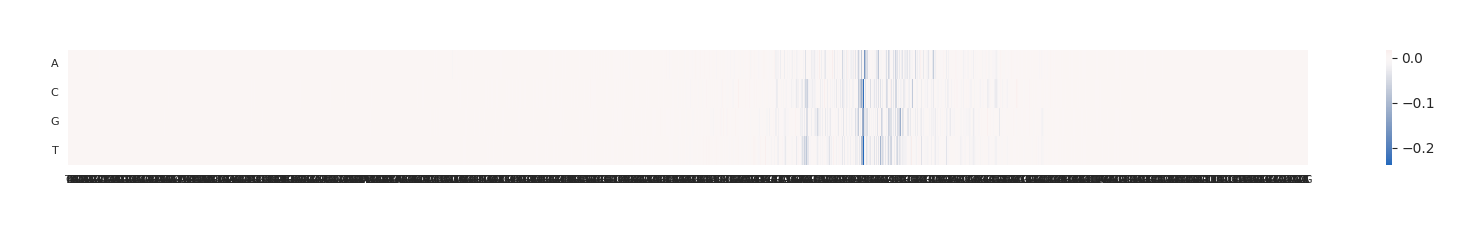

In [104]:
grelu.visualize.plot_ISM(new_ism, method="heatmap", figsize=(20, 1.5), center=0) 

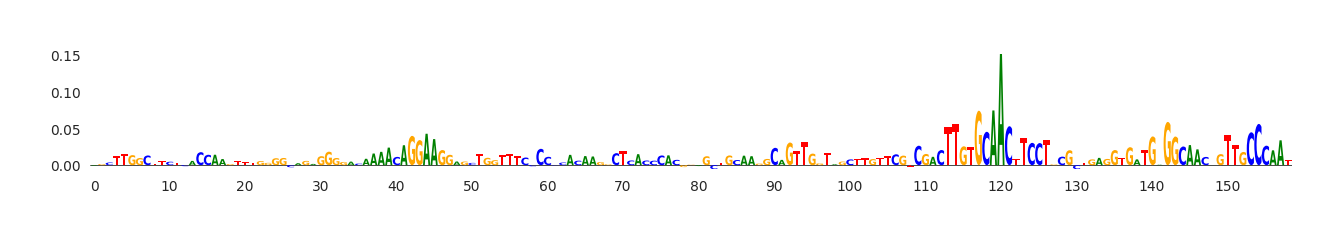

In [105]:
grelu.visualize.plot_ISM(new_ism, method="logo", figsize=(15.5, 1.5),
                        start_pos=940,end_pos = 1100)

## Identify motifs

In [106]:
from grelu.interpret.motifs import scan_sequences
import grelu.interpret.motifs
import grelu.visualize


In [107]:
best_enhancer = best_seq[enhancer_start - input_start:enhancer_end - input_start]
original_enhancer_sequence= input_seq[enhancer_start - input_start:enhancer_end - input_start]

In [111]:
scan = scan_sequences(
        seqs=[original_enhancer_sequence, best_enhancer],
        motifs="/gstore/data/resbioai/gunsalul/annotations/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt",
        names=None,
        seq_ids=["original", "evolved"],
        pthresh=5e-4,
        rc=True,  
    )
scan = scan[scan['motif'].str.isupper()]

Read 879 motifs from file.


In [140]:
def calculate_ism_weight(row: pd.Series, ism: np.ndarray) -> float:
    max_ism = np.abs(ism).max(axis=0)
    start, end = min(row["start"], row["end"]), max(row["start"], row["end"])
    return max_ism[start:end].mean()
    
scan['ism_weight'] = scan.apply(calculate_ism_weight, ism=new_ism, axis=1)

In [151]:
scan.sort_values(by='ism_weight', ascending=False).head(20)

,motif,sequence,start,end,strand,score,pval,ism_weight
2458,NFIL3,evolved,1054,1062,+,9.489510,0.000174,0.119384
2107,HLF,evolved,1054,1062,+,11.954955,0.000054,0.119384
599,CEBPG,evolved,1053,1062,+,9.061224,0.000125,0.114591
601,CEBPG,evolved,1062,1053,-,6.979592,0.000247,0.114591
1309,CEBPB,evolved,1053,1062,+,6.576923,0.000122,0.114591
1318,CEBPE,evolved,1062,1053,-,7.730769,0.000119,0.114591
1307,CEBPA,evolved,1062,1053,-,12.406504,0.000027,0.114591
1311,CEBPB,evolved,1062,1053,-,6.326923,0.000128,0.114591
1317,CEBPE,evolved,1053,1062,+,7.807692,0.000114,0.114591
1436,DBP,evolved,1062,1053,-,6.115385,0.000406,0.114591


NFIL3
HLF
CEBPG
CEBPG
CEBPB
CEBPE
CEBPA
CEBPB
CEBPE
DBP
DBP
CEBPD
MTF1
ELK1::SREBF2
ETV7
ELF3
ELF1
ZBTB11
EHF
ELK4


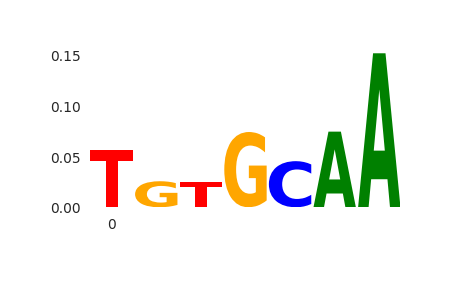

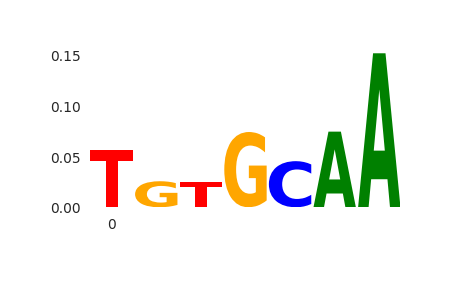

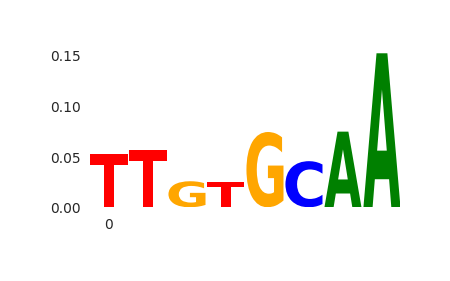

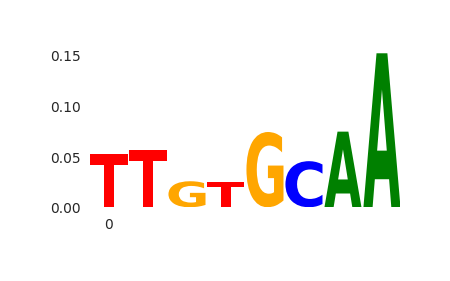

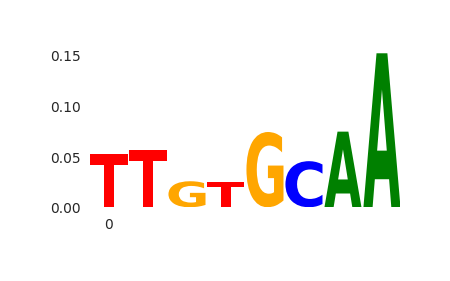

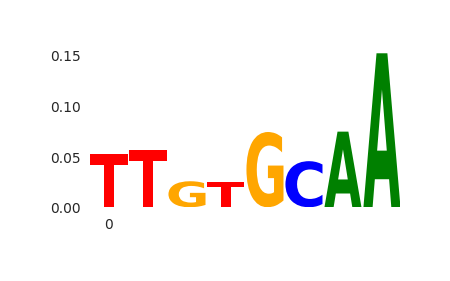

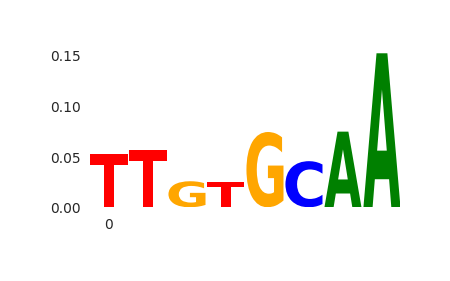

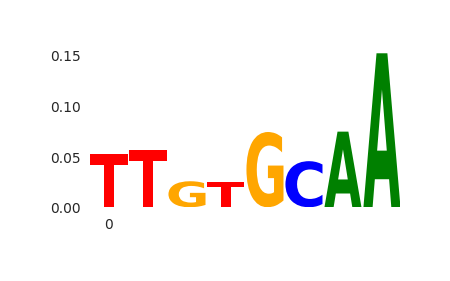

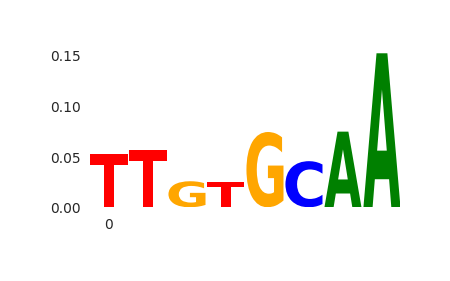

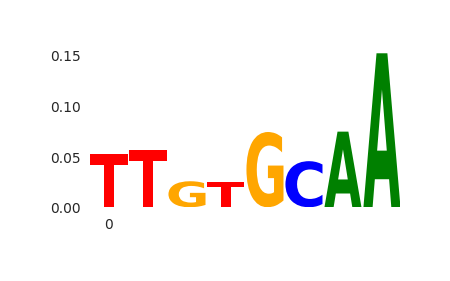

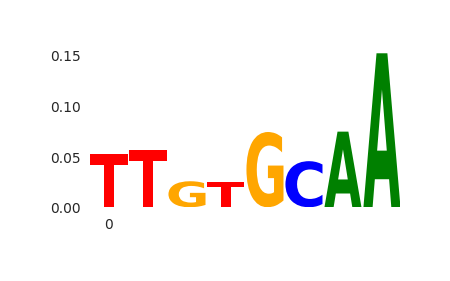

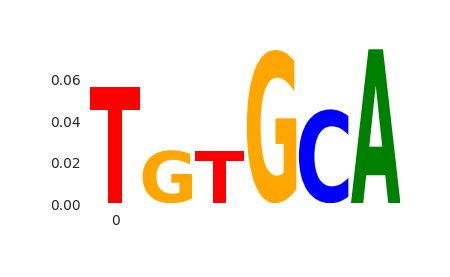

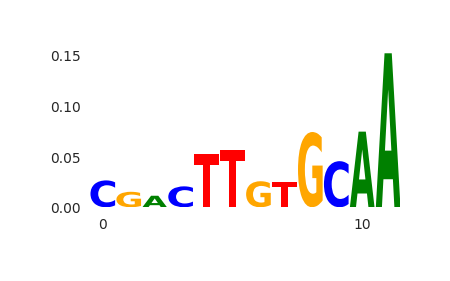

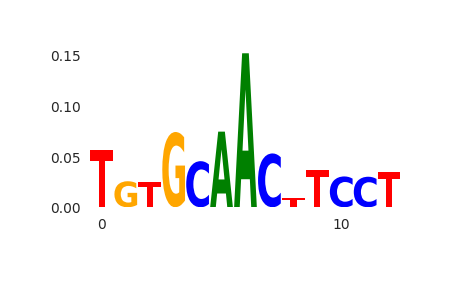

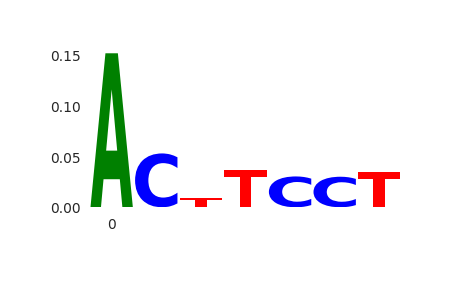

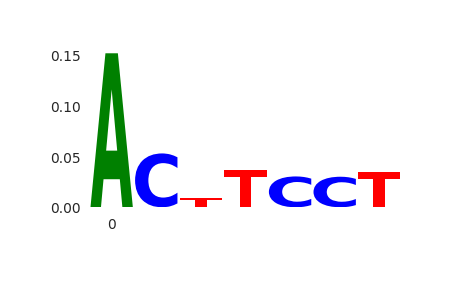

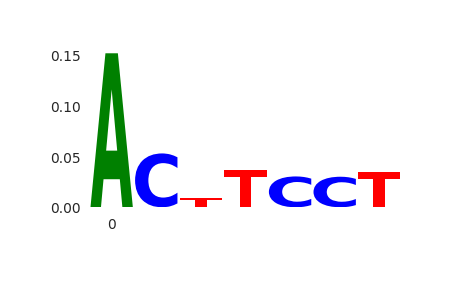

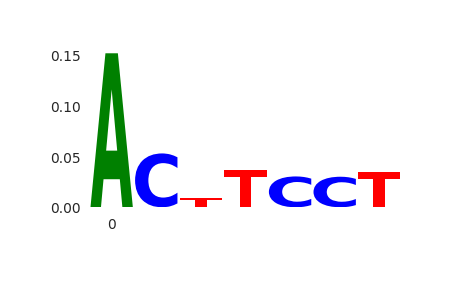

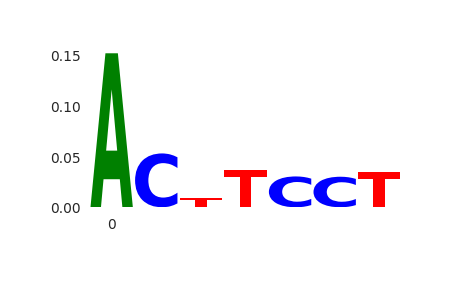

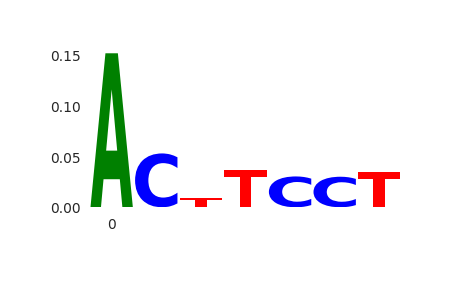

In [157]:
for i, row in scan.sort_values(by='ism_weight', ascending=False).head(20).iterrows():
    print(f'{row["motif"]}')
    min_pos = min(row['start'], row['end'])
    max_pos = max(row['start'], row['end'])
    grelu.visualize.plot_ISM(new_ism, method="logo", figsize=(4,2), 
                         start_pos = min_pos, end_pos=max_pos)  